In [ ]:
!pip install catboost scikit-learn pandas matplotlib tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from catboost import CatBoostClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import joblib

In [ ]:
dry_run_df = pd.read_csv("/content/dryrun_combined.csv")
benign_df = pd.read_csv("/content/benginware_combined.csv")
malware_df = pd.read_csv("/content/malware_system_metrics_combined.csv")

In [ ]:
# Merge datasets
df = pd.concat([dry_run_df, benign_df, malware_df], ignore_index=True)
#df = pd.read_csv("/content/shuffled_dataset.csv")
df.describe()

,CPU Usage (%),RAM Usage (%),CPU Temp (°C),Disk Read (KB/s),Disk Write (KB/s),Network Out (KB/s),Process ID,Ransomware
count,7648.000000,7648.000000,7648.000000,7648.000000,7648.000000,7648.000000,7648.000000,7648.000000
mean,22.295829,45.757309,53.099503,540.057945,1128.280581,7.473474,8538.051124,0.069691
std,29.865630,14.182997,17.436992,2162.385170,2288.865081,25.997096,6851.422927,0.254643
min,0.500000,25.300000,34.750000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,1.500000,33.400000,38.375000,1.450000,157.130000,0.040000,1826.000000,0.000000
50%,6.700000,44.900000,45.750000,13.860000,160.085000,0.040000,8382.000000,0.000000
75%,37.625000,51.600000,67.781250,251.415000,1610.605000,6.962500,14598.000000,0.000000
max,100.000000,92.900000,96.375000,22868.480000,21947.510000,301.120000,28043.000000,1.000000


In [ ]:
df.drop(columns=["Timestamp", "Process Name"], inplace=True)

# Convert labels (0: Benign, 1: Ransomware)
df["Ransomware"] = df["Ransomware"].astype(int)

# Features & Labels
X = df.drop("Ransomware", axis=1)
y = df["Ransomware"]

# Standard Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save the scaler for later
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [ ]:
iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_forest.fit(X_scaled)

# Save model
joblib.dump(iso_forest, "isolation_forest.pkl")


['isolation_forest.pkl']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

catboost_model = CatBoostClassifier(verbose=0)
catboost_model.fit(X_train, y_train)

# Evaluate
y_pred = catboost_model.predict(X_test)
print("CatBoost Classifier Report:")
print(classification_report(y_test, y_pred))

# Save model
joblib.dump(catboost_model, "catboost_model.pkl")


CatBoost Classifier Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2146
           1       0.97      0.99      0.98       149

    accuracy                           1.00      2295
   macro avg       0.99      0.99      0.99      2295
weighted avg       1.00      1.00      1.00      2295



['catboost_model.pkl']

In [ ]:
def create_sequences(data, labels, window_size=10):
    X_seq, y_seq = [], []
    for i in range(len(data) - window_size):
        X_seq.append(data[i:i + window_size])
        y_seq.append(labels[i + window_size])
    return np.array(X_seq), np.array(y_seq)

X_lstm, y_lstm = create_sequences(X_scaled, y.values)

# Train/test split
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)


In [ ]:
model = Sequential()
model.add(LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

history = model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32, validation_data=(X_test_lstm, y_test_lstm))

# Save model
model.save("lstm_model.keras")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,497 (72.25 KB)

 Trainable params: 18,497 (72.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8915 - loss: 0.2705 - val_accuracy: 0.9725 - val_loss: 0.0523
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9703 - loss: 0.0535 - val_accuracy: 0.9719 - val_loss: 0.0481
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9681 - loss: 0.0526 - val_accuracy: 0.9738 - val_loss: 0.0480
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9717 - loss: 0.0493 - val_accuracy: 0.9725 - val_loss: 0.0464
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9681 - loss: 0.0545 - val_accuracy: 0.9712 - val_loss: 0.0459
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9731 - loss: 0.0458 - val_accuracy: 0.9699 - val_loss: 0.0476
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9717 - loss: 0.0431 - val_accuracy: 0.9725 - val_loss: 0.0460
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9697 - loss: 0.0501 - val_accura

In [ ]:
y_pred_lstm = (model.predict(X_test_lstm) > 0.5).astype("int32")
print("LSTM Report:")
print(classification_report(y_test_lstm, y_pred_lstm))


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
LSTM Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1408
           1       0.77      0.91      0.84       120

    accuracy                           0.97      1528
   macro avg       0.88      0.94      0.91      1528
weighted avg       0.97      0.97      0.97      1528



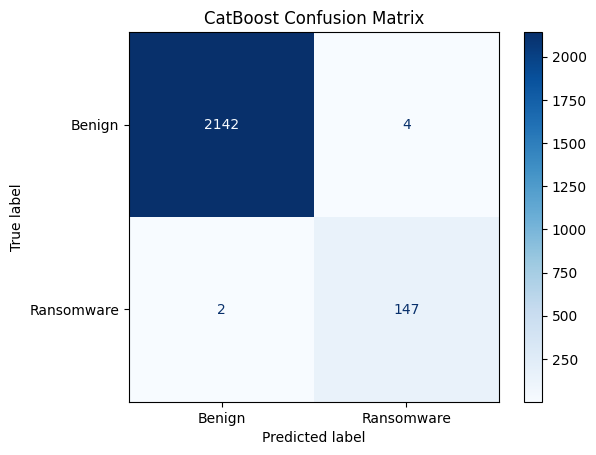

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict
y_pred_catboost = catboost_model.predict(X_test)

# Confusion Matrix
cm_cat = confusion_matrix(y_test, y_pred_catboost)
disp_cat = ConfusionMatrixDisplay(confusion_matrix=cm_cat, display_labels=["Benign", "Ransomware"])
disp_cat.plot(cmap="Blues")
plt.title("CatBoost Confusion Matrix")
plt.show()


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


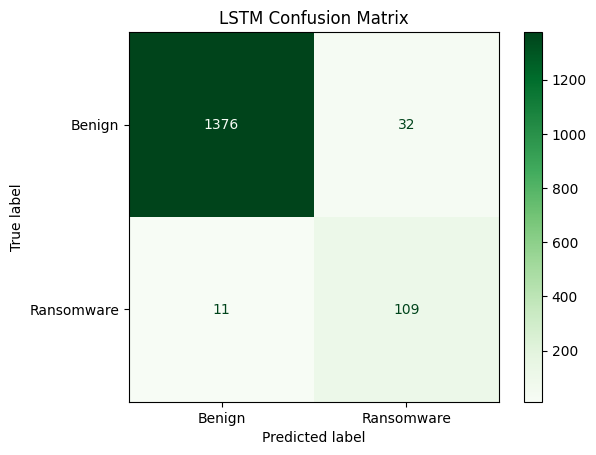

In [ ]:
# Predict and threshold
y_pred_lstm = (model.predict(X_test_lstm) > 0.5).astype("int32")

# Confusion Matrix
cm_lstm = confusion_matrix(y_test_lstm, y_pred_lstm)
disp_lstm = ConfusionMatrixDisplay(confusion_matrix=cm_lstm, display_labels=["Benign", "Ransomware"])
disp_lstm.plot(cmap="Greens")
plt.title("LSTM Confusion Matrix")
plt.show()


In [ ]:
# ✅ Reshape NumPy arrays directly
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the LSTM model
lstm_model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], 1)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8848 - loss: 0.4042 - val_accuracy: 0.9272 - val_loss: 0.1608
Epoch 2/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9475 - loss: 0.1350 - val_accuracy: 0.9608 - val_loss: 0.0604
Epoch 3/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9711 - loss: 0.0553 - val_accuracy: 0.9935 - val_loss: 0.0197
Epoch 4/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9915 - loss: 0.0264 - val_accuracy: 0.9841 - val_loss: 0.0391
Epoch 5/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9848 - loss: 0.0362 - val_accuracy: 0.9916 - val_loss: 0.0195
Epoch 6/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9866 - loss: 0.0327 - val_accuracy: 0.9916 - val_loss: 0.0192
Epoch 7/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9864 - loss: 0.0305 - val_accuracy: 0.9907 - val_loss: 0.0279
Epoch 8/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9892 - loss: 0.0254 - val_accuracy: 0.9953 - v

In [ ]:
# Predict using LSTM
y_pred_lstm = (lstm_model.predict(X_test_lstm, verbose=0) > 0.5).astype("int32").flatten()


✅ Ensemble Model Accuracy: 0.9978


<Figure size 600x500 with 0 Axes>

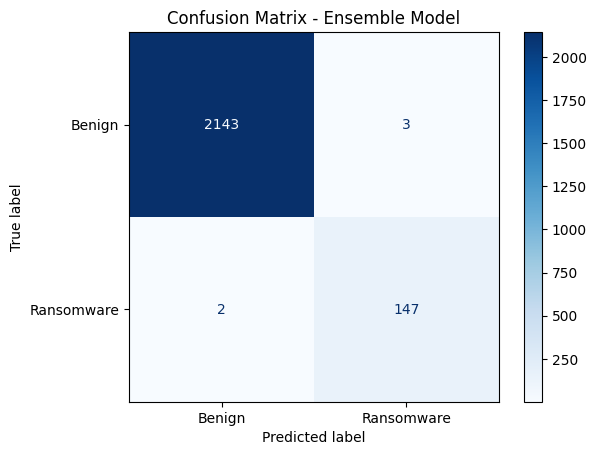

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np

# 1️⃣ Isolation Forest predictions (if not already done)
isolation_forest = IsolationForest(contamination=0.1, random_state=42)
isolation_forest.fit(X_train)
y_pred_iforest = isolation_forest.predict(X_test)
y_pred_iforest = np.array([1 if x == -1 else 0 for x in y_pred_iforest])  # Convert -1 to 1 (ransomware)

# 2️⃣ Stack predictions
stacked_preds = np.column_stack((y_pred_catboost, y_pred_iforest, y_pred_lstm))

# 3️⃣ Meta-model training
meta_model = LogisticRegression()
meta_model.fit(stacked_preds, y_test)

# 4️⃣ Final prediction
final_pred = meta_model.predict(stacked_preds)

# 5️⃣ Accuracy
accuracy = accuracy_score(y_test, final_pred)
print(f"✅ Ensemble Model Accuracy: {accuracy:.4f}")

# 6️⃣ Confusion Matrix
cm = confusion_matrix(y_test, final_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Ransomware"])
plt.figure(figsize=(6, 5))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Ensemble Model")
plt.show()


In [ ]:
history = lstm_model.fit(X_train_lstm, y_train,
                         epochs=10,
                         batch_size=32,
                         validation_data=(X_test_lstm, y_test))


Epoch 1/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9906 - loss: 0.0240 - val_accuracy: 0.9900 - val_loss: 0.0275
Epoch 2/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9920 - loss: 0.0236 - val_accuracy: 0.9922 - val_loss: 0.0183
Epoch 3/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9910 - loss: 0.0217 - val_accuracy: 0.9952 - val_loss: 0.0151
Epoch 4/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9937 - loss: 0.0201 - val_accuracy: 0.9956 - val_loss: 0.0139
Epoch 5/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9914 - loss: 0.0254 - val_accuracy: 0.9952 - val_loss: 0.0147
Epoch 6/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9926 - loss: 0.0226 - val_accuracy: 0.9961 - val_loss: 0.0157
Epoch 7/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9899 - loss: 0.0267 - val_accuracy: 0.9948 - val_loss: 0.0147
Epoch 8/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9928 - loss: 0.0216 - val_accuracy:

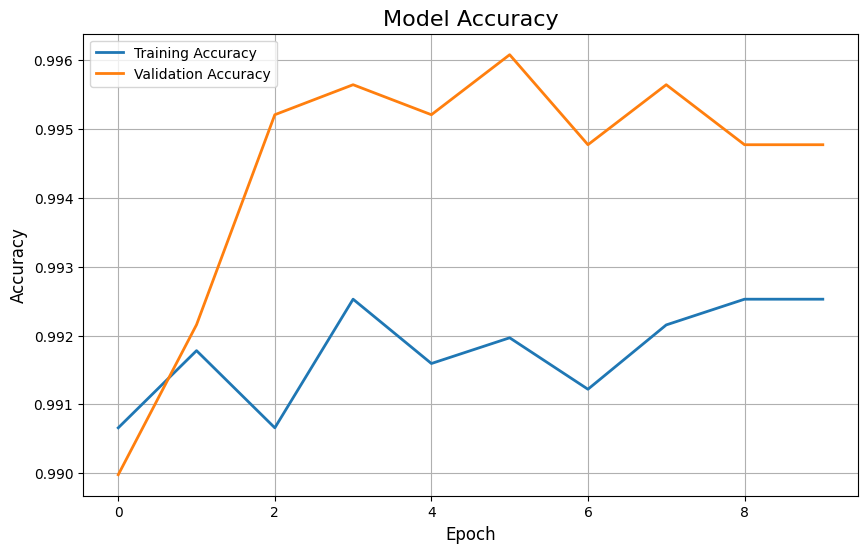

In [ ]:
import matplotlib.pyplot as plt

# 📊 Plot Training & Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from google.colab import files

In [ ]:
files.download('catboost_model.pkl')
files.download('isolation_forest.pkl')
files.download('lstm_model.keras')
files.download('meta_model.pkl')


NameError: name 'files' is not defined

In [ ]:
import joblib

# Save the meta_model to a file
joblib.dump(meta_model, 'meta_model.pkl')

# Download the meta_model
from google.colab import files
files.download('meta_model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>